# Example on LPV identification (Example 3 in the paper)

Lugano, 04/09/2023

Note: This notebook is not written following good code writing practices, but only for fast generation of results related to the LPV identification example reported in the paper. Use this script only to regenerate the results of the paper. If you are interested in using gradient-based hyperparameter optimization for multi-ridge regression, please use the other scripts available in the GitHub repository.

In [2]:
# Import packages

import sys
import numpy as np
import pandas as pd
import torch
import scipy

sys.path.append('..') 

from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns 

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import warnings
warnings.filterwarnings('ignore')

from matplotlib.cm import get_cmap
name = "tab20"
cmap = get_cmap(name)
colors = cmap.colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### PYTORCH
DTYPE = torch.float64
DEVICE = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)

### CROSS VALIDATION
NUM_FOLDS = 5
SHUFFLE = True

# Set seed for reproducibility
SEED = 43
torch.manual_seed(SEED)
np.random.seed(SEED)

EPOCHS = 200

Using device: cuda:2


In [4]:
# Generate data

def generate_LPV_data(N, n_lag = 10,  sigmay = 1):
    # generate data from LPV system described in the paper
    
    U = np.random.randn(N,1)
    P =  np.random.rand(N)*np.pi

    a1P = 0*np.sin(P)
    a2P = 0.5*np.cos(P)
    a3P = -0.1*np.sin(P)**2
    b1P = 0*np.sin(P) 
    b2P = -1*np.sin(P) + 1*np.cos(P)
    b3P = 3*np.sin(P)


    Y0 = np.zeros((N,1))
    Y = np.zeros((N,1))
    err = np.zeros((N,1))


    for ind in range(n_lag, N):
        Y0[ind,0] = a1P[ind] * Y[ind - 1,0] + a2P[ind] * Y[ind - 2,0] + a3P[ind] * Y[ind- 3,0] + \
                            b1P[ind] * U[ind - 1,0] + b2P[ind] * U[ind- 2,0] + b3P[ind] * U[ind- 3,0]
    
        
        err[ind,0] = np.random.randn(1)*sigmay       
        Y[ind,0] = Y0[ind,0] + err[ind,0]
  
    SNR = 10*np.log10(np.var(Y0)/np.var(err))
    print(f"Actual SNR {SNR}")

    return U, Y, P, SNR

In [5]:
# Create regressor

def split_train_test(U, Y, P, N, N_train):

    P0_reg = np.ones((N,1))
    P1_reg = P.reshape(-1,1)
    P2_reg = (P**2).reshape(-1,1)
    P3_reg = (P**3).reshape(-1,1)
    P4_reg = (P**4).reshape(-1,1)
    P5_reg = (P**5).reshape(-1,1)
    Psin_reg = (np.sin(P)).reshape(-1,1)
    Pcos_reg = (np.cos(P)).reshape(-1,1)
    Psin2_reg = (np.sin(P)**2).reshape(-1,1)
    Pcos2_reg = (np.cos(P)**2).reshape(-1,1)
    Psin3_reg = (np.sin(P)**3).reshape(-1,1)
    Pcos3_reg = (np.cos(P)**3).reshape(-1,1)
    Psincos_reg = (np.sin(P)*np.cos(P)).reshape(-1,1)
    Psin2cos_reg = (np.sin(P)**2*np.cos(P)).reshape(-1,1)
    Psincos2_reg = (np.sin(P)*np.cos(P)**2).reshape(-1,1)
    Psin2cos2_reg = (np.sin(P)**2*np.cos(P)**2).reshape(-1,1)

    P_reg = np.concatenate((P0_reg, P1_reg, P2_reg, P3_reg, Psin_reg, Pcos_reg, Psin2_reg, Pcos2_reg), axis = 1)
    
    X_temp_reg = np.zeros((N, n_lag*2))
    X_reg = np.zeros((N, n_lag*2*np.shape(P_reg)[1]))
    
    for ind in range(n_lag, N):
        X_temp_reg[ind,:] = np.concatenate((Y[ind-n_lag:ind,0], U[ind-n_lag:ind,0] )) 
        X_reg[ind,:] = np.kron(P_reg[ind,:], X_temp_reg[ind,:] )
    
    
    X_reg = X_reg[n_lag:,:]
    
    Y = Y[n_lag:,:]
    
    X_reg_mean = np.mean(X_reg[0:N_train], axis =0)
    X_reg_std = np.std(X_reg[0:N_train], axis =0)
    
    X_reg = (X_reg - X_reg_mean)/X_reg_std
    
    D = np.shape(X_reg)[1]
    
    
    features = [f'x{i}' for i in range(1,D+1)]
    X_reg = pd.DataFrame(data=X_reg, columns=features)
    target = 'y'
    Y_reg = pd.DataFrame(Y, columns=[target])
    
    
    ## Train-test splitting
    comb = pd.concat([X_reg, Y_reg], axis=1)
    train = comb.iloc[:int(N_train)].reset_index(drop=True).copy()
    test = comb.iloc[int(N_train):].reset_index(drop=True).copy()


    
    return train, test, X_reg_mean, X_reg_std, D, features, target

# Baseline

In [6]:
## Simple Ridge regression

def LPV_ridge(train, folds, features, target):
    params = dict()
    params['alpha'] = np.logspace(-2, 5, 100, endpoint=True)
    scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
    
    ridge = Ridge(fit_intercept=False)
    
    gs_ridge = GridSearchCV(ridge, params, scoring=scoring, cv=folds, verbose=0, refit='r2', return_train_score=True, n_jobs=100)
    gs_ridge.fit(train[features], train[target])
    df_ridge = pd.DataFrame(gs_ridge.cv_results_)

    α_ridge = df_ridge.sort_values('rank_test_r2').iloc[0]['param_alpha']
   
    return df_ridge, α_ridge



In [7]:
## LASSO

def LPV_lasso(train, folds, features, target):
    params = dict()
    params['alpha'] = np.logspace(-2, 4, 200, endpoint=True)
    scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
    
    lasso = Lasso(fit_intercept=False)
    
    gs_lasso = GridSearchCV(lasso, params, scoring=scoring, cv=folds, verbose=0, refit='r2', return_train_score=True, n_jobs=100)
    gs_lasso.fit(train[features], train[target])
    df_lasso = pd.DataFrame(gs_lasso.cv_results_)

    α_lasso = df_lasso.sort_values('rank_test_r2').iloc[0]['param_alpha']

    return df_lasso, α_lasso

In [8]:
## Elastic Net

def LPV_enet(train, folds, features, target):
    params = dict()
    params['alpha'] =  np.logspace(-5, 5, 10, endpoint=True)
    params['l1_ratio'] = np.arange(0, 1, 0.1)
    
    scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
    
    enet = ElasticNet(fit_intercept=False)
    
    
    gs_enet = RandomizedSearchCV(enet, params, n_iter=2000, scoring=scoring, cv=folds, verbose=0, refit='r2', return_train_score=True, n_jobs=100)
    gs_enet.fit(train[features], train[target])
    df_enet = pd.DataFrame(gs_enet.cv_results_)

    l1_ratio, α_enet = df_enet.sort_values('rank_test_r2').iloc[0][['param_l1_ratio', 'param_alpha']]
    

    return df_enet, l1_ratio, α_enet

In [9]:
def baseline(folds, α_lasso, α_ridge, α_enet, l1_ratio, features, target):

    df = pd.DataFrame(data=0.0, columns=['mse_train', 'mse_valid', 'mse_test', 'r2_train', 'r2_valid', 'r2_test'],
                      index=['Least_Square', 'Ridge', 'Lasso', 'ElasticNet'])
    
    for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(folds):
        train_fold = train.loc[train_fold_idx].copy()
        valid_fold = train.loc[valid_fold_idx].copy()
    
        ## Least Square
        lr = LinearRegression(fit_intercept=False)
        lr.fit(train_fold[features], train_fold[target])
        train_preds = lr.predict(train_fold[features])
        valid_preds = lr.predict(valid_fold[features])
        test_preds  = lr.predict(test[features])
        df.loc['Least_Square', 'mse_train'] += mean_squared_error(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Least_Square', 'mse_valid'] += mean_squared_error(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Least_Square', 'mse_test']  += mean_squared_error(test[target], test_preds)/NUM_FOLDS
        df.loc['Least_Square', 'r2_train']  += r2_score(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Least_Square', 'r2_valid']  += r2_score(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Least_Square', 'r2_test']   += r2_score(test[target], test_preds)/NUM_FOLDS
    
        ## Ridge
        ridge = Ridge(alpha=α_ridge, fit_intercept=False)
        ridge.fit(train_fold[features], train_fold[target])
        train_preds = ridge.predict(train_fold[features])
        valid_preds = ridge.predict(valid_fold[features])
        test_preds  = ridge.predict(test[features])
        df.loc['Ridge', 'mse_train'] += mean_squared_error(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Ridge', 'mse_valid'] += mean_squared_error(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Ridge', 'mse_test']  += mean_squared_error(test[target], test_preds)/NUM_FOLDS
        df.loc['Ridge', 'r2_train']  += r2_score(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Ridge', 'r2_valid']  += r2_score(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Ridge', 'r2_test']   += r2_score(test[target], test_preds)/NUM_FOLDS
    
        ## Lasso
        lasso = Lasso(alpha=α_lasso, fit_intercept=False)
        lasso.fit(train_fold[features], train_fold[target])
        train_preds = lasso.predict(train_fold[features])
        valid_preds = lasso.predict(valid_fold[features])
        test_preds  = lasso.predict(test[features])
        df.loc['Lasso', 'mse_train'] += mean_squared_error(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Lasso', 'mse_valid'] += mean_squared_error(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Lasso', 'mse_test']  += mean_squared_error(test[target], test_preds)/NUM_FOLDS
        df.loc['Lasso', 'r2_train']  += r2_score(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['Lasso', 'r2_valid']  += r2_score(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['Lasso', 'r2_test']   += r2_score(test[target], test_preds)/NUM_FOLDS
    
        ## ElasticNet
        enet = ElasticNet(alpha=α_enet, l1_ratio=l1_ratio, fit_intercept=False)
        enet.fit(train_fold[features], train_fold[target])
        train_preds = enet.predict(train_fold[features])
        valid_preds = enet.predict(valid_fold[features])
        test_preds  = enet.predict(test[features])
        df.loc['ElasticNet', 'mse_train'] += mean_squared_error(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['ElasticNet', 'mse_valid'] += mean_squared_error(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['ElasticNet', 'mse_test']  += mean_squared_error(test[target], test_preds)/NUM_FOLDS
        df.loc['ElasticNet', 'r2_train']  += r2_score(train_fold[target], train_preds)/NUM_FOLDS
        df.loc['ElasticNet', 'r2_valid']  += r2_score(valid_fold[target], valid_preds)/NUM_FOLDS
        df.loc['ElasticNet', 'r2_test']   += r2_score(test[target], test_preds)/NUM_FOLDS


    idx_LASSO = np.where(np.isclose(lasso.coef_, -0.0))[0].tolist()
    idx_not_zero_LASSO = list(set(np.arange(len(lasso.coef_))) - set(idx_LASSO))
    
    return df, lasso

In [10]:
def diff_regularization(train, folds, features, target, idx_not_zero_LASSO = []):


    history_df = pd.DataFrame(data=0.0, columns=['mse_train', 'mse_valid', 'mse_test', 'r2_train', 'r2_valid', 'r2_test', 'mse_valid_reg'],
                              index=range(EPOCHS))
    
    Id = torch.eye(D, device=DEVICE, dtype=DTYPE)
    ones = torch.ones(D,1, device=DEVICE, dtype=DTYPE)
    theta_hat_history = np.zeros(shape=(EPOCHS, D), dtype=np.float64)
    Λ_history = np.zeros(shape=(EPOCHS, D), dtype=np.float64)
       
    λ = torch.tensor(np.ones(D)*10.0, device=DEVICE, dtype=DTYPE)
    λ[idx_not_zero_LASSO] = λ[idx_not_zero_LASSO]*0.0 + 1
    
    gamma_list = [0.5, 1, 2]
    NUM_GAMMA = len(gamma_list)
    mu = 0.01 
    
    for k in tqdm(range(EPOCHS), total=EPOCHS):
    
        grad_E_cv = 0.0
        theta_hat = torch.zeros(D,1, device=DEVICE, dtype=DTYPE)
    
        kf = KFold(n_splits=NUM_FOLDS, shuffle=SHUFFLE, random_state=SEED*k)
        folds = []
        for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(kf.split(train[features], train[target])):
            train_fold = train.loc[train_fold_idx].copy()
            valid_fold = train.loc[valid_fold_idx].copy()
    
            X_train_fold = train_fold[features].values
            X_valid_fold = valid_fold[features].values
            X_test       = test[features].values
            Y_train_fold = train_fold[target].values[:,np.newaxis]
            Y_valid_fold = valid_fold[target].values[:,np.newaxis]
            Y_test       = test[target].values[:,np.newaxis]
    
            X_train_fold = torch.tensor(X_train_fold, device=DEVICE, dtype=DTYPE)
            X_valid_fold = torch.tensor(X_valid_fold, device=DEVICE, dtype=DTYPE)
            X_test       = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
            Y_train_fold = torch.tensor(Y_train_fold, device=DEVICE, dtype=DTYPE)
            Y_valid_fold = torch.tensor(Y_valid_fold, device=DEVICE, dtype=DTYPE)
            Y_test       = torch.tensor(Y_test, device=DEVICE, dtype=DTYPE)
            N_train_fold, N_valid_fold = X_train_fold.shape[0], X_valid_fold.shape[0]
    
            for gamma in gamma_list:
              Λ = torch.diag(λ)
              theta_fold_hat = torch.linalg.lstsq(X_train_fold.T @ X_train_fold + N_train_fold * (gamma)**2 * Λ@Λ, X_train_fold.T @ Y_train_fold)[0]
    
              Y_train_fold_hat = X_train_fold @ theta_fold_hat
              Y_valid_fold_hat = X_valid_fold @ theta_fold_hat
              Y_test_hat       = X_test @ theta_fold_hat
    
              history_df.loc[k, 'mse_train'] += mean_squared_error(Y_train_fold.cpu().numpy(), Y_train_fold_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'mse_valid'] += mean_squared_error(Y_valid_fold.cpu().numpy(), Y_valid_fold_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'mse_valid_reg'] = history_df.loc[k, 'mse_valid'] + 0.5*mu/D * (torch.linalg.norm(Λ@theta_fold_hat)**2).cpu().numpy()/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'mse_test']  += mean_squared_error(Y_test.cpu().numpy(), Y_test_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'r2_train']  += r2_score(Y_train_fold.cpu().numpy(), Y_train_fold_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'r2_valid']  += r2_score(Y_valid_fold.cpu().numpy(), Y_valid_fold_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
              history_df.loc[k, 'r2_test']   += r2_score(Y_test.cpu().numpy(), Y_test_hat.cpu().numpy())/(NUM_FOLDS*NUM_GAMMA)
    
              R_fold = (Y_valid_fold_hat - Y_valid_fold)
              B_fold = torch.linalg.lstsq((X_train_fold.T @ X_train_fold + N_train_fold * (gamma)**2 * Λ@Λ).T, X_valid_fold.T @ R_fold @ theta_fold_hat.T)[0]

    
              D_fold = Λ@theta_fold_hat
              C_fold = torch.linalg.lstsq((X_train_fold.T @ X_train_fold + N_train_fold * Λ@Λ).T, Λ.T @ D_fold @ theta_fold_hat.T)[0]
              grad_E_fold = torch.diagonal(-(N_train_fold/N_valid_fold) * ((gamma*Λ)@B_fold + B_fold@(Λ*gamma)).T + mu/D*(D_fold@theta_fold_hat.T - N_train_fold*(Λ@C_fold + C_fold@Λ)).T)
                

    
              grad_E_cv += grad_E_fold/(NUM_FOLDS*NUM_GAMMA)
              theta_hat += theta_fold_hat/(NUM_FOLDS*NUM_GAMMA)
    
        λ = λ - 1*grad_E_cv
    
        idx_lambda = torch.abs(λ) <= 0.001

        theta_hat_history[k] = theta_hat.cpu().numpy().ravel()
        Λ_history[k] = λ.cpu().numpy().ravel()
    
        λ.cpu().numpy()*theta_fold_hat.cpu().numpy()
        
        if k%10 == 0:
          print(f"Iteration: {k}")  
          print(f"R2 valid: {history_df.loc[k, 'r2_valid']}")
          print(f"R2 test: {history_df.loc[k, 'r2_test']}")
          print(f"Norm gradient of lambda: {torch.norm(grad_E_cv)}")
    
    return λ     
    


In [11]:
def multi_par_results(λ):

    df = pd.DataFrame(data=0.0, columns=['mse_train', 'mse_valid', 'mse_test', 'r2_train', 'r2_valid', 'r2_test'], index=range(1))
    
    
    mask = torch.abs(λ) <=0.01
    λ_zeros = torch.clone(λ)
    
    mask = torch.abs(λ) >0.05
    
    for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(kf.split(train[features], train[target])):
        train_fold = train.loc[train_fold_idx].copy()
        valid_fold = train.loc[valid_fold_idx].copy()
    
        X_train_fold = train_fold[features].values
        X_valid_fold = valid_fold[features].values
        X_test       = test[features].values
        Y_train_fold = train_fold[target].values[:,np.newaxis]
        Y_valid_fold = valid_fold[target].values[:,np.newaxis]
        Y_test       = test[target].values[:,np.newaxis]
    

        X_train_fold = torch.tensor(X_train_fold, device=DEVICE, dtype=DTYPE)
        X_valid_fold = torch.tensor(X_valid_fold, device=DEVICE, dtype=DTYPE)
        X_test       = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
        Y_train_fold = torch.tensor(Y_train_fold, device=DEVICE, dtype=DTYPE)
        Y_valid_fold = torch.tensor(Y_valid_fold, device=DEVICE, dtype=DTYPE)
        Y_test       = torch.tensor(Y_test, device=DEVICE, dtype=DTYPE)
        N_train_fold, N_valid_fold = X_train_fold.shape[0], X_valid_fold.shape[0]
    
        Λ = torch.diag(λ_zeros)
        theta_fold_hat = torch.linalg.lstsq(X_train_fold.T @ X_train_fold + N_train_fold * Λ@Λ, X_train_fold.T @ Y_train_fold)[0]
    
        Y_train_fold_hat = X_train_fold @ theta_fold_hat
        Y_valid_fold_hat = X_valid_fold @ theta_fold_hat
        Y_test_hat       = X_test @ theta_fold_hat
    
        df.loc[0, 'mse_train'] += mean_squared_error(Y_train_fold.cpu().numpy(), Y_train_fold_hat.cpu().numpy())/NUM_FOLDS
        df.loc[0, 'mse_valid'] += mean_squared_error(Y_valid_fold.cpu().numpy(), Y_valid_fold_hat.cpu().numpy())/NUM_FOLDS
        df.loc[0, 'mse_test']  += mean_squared_error(Y_test.cpu().numpy(), Y_test_hat.cpu().numpy())/NUM_FOLDS
        df.loc[0, 'r2_train']  += r2_score(Y_train_fold.cpu().numpy(), Y_train_fold_hat.cpu().numpy())/NUM_FOLDS
        df.loc[0, 'r2_valid']  += r2_score(Y_valid_fold.cpu().numpy(), Y_valid_fold_hat.cpu().numpy())/NUM_FOLDS
        df.loc[0, 'r2_test']   += r2_score(Y_test.cpu().numpy(), Y_test_hat.cpu().numpy())/NUM_FOLDS
    
    return df



In [ ]:
# main file

sigmay = 0.5
N = 3000 
n_lag = 30
N_train = 50 
N_examples = 200

r2_LS = []
r2_lasso = []
r2_elnet = []
r2_ridge = []
r2_multipar = []


for ind in range(N_examples):
    print(ind)
    U, Y, P, SNR = generate_LPV_data(N, n_lag = n_lag,  sigmay = sigmay) 
    
    train, test, X_reg_mean, X_reg_std, D, features, target = split_train_test(U, Y, P, N, N_train)
    
    ## Cross-validation
    kf = KFold(n_splits=NUM_FOLDS, shuffle=SHUFFLE, random_state=SEED)
    folds = []
    for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(kf.split(train[features], train[target])):
        folds.append((train_fold_idx, valid_fold_idx))
    
    
    df_ridge, α_ridge = LPV_ridge(train, folds, features, target)
    df_lasso, α_lasso = LPV_lasso(train, folds, features, target)
    df_enet, l1_ratio, α_enet = LPV_enet(train, folds, features, target)
    
    df_baseline, lasso = baseline(folds, α_lasso, α_ridge, α_enet, l1_ratio, features, target)
    print(df_baseline)
    
    
    r2_lasso.append(df_baseline.loc['Lasso']['r2_test'])
    r2_LS.append(df_baseline.loc['Least_Square']['r2_test'])
    r2_ridge.append(df_baseline.loc['Ridge']['r2_test'])
    r2_elnet.append(df_baseline.loc['ElasticNet']['r2_test'])
    
    
    idx_LASSO = np.where(np.isclose(lasso.coef_, -0.0))[0].tolist()
    idx_not_zero_LASSO = list(set(np.arange(len(lasso.coef_))) - set(idx_LASSO))
    
    # Differential regularization
    λ = diff_regularization(train, folds, features, target, idx_not_zero_LASSO = idx_not_zero_LASSO)
    df = multi_par_results(λ)
    
    print('Results Multiparametric:')
    print(df)
    r2_multipar.append(df.iloc[0]['r2_test'])

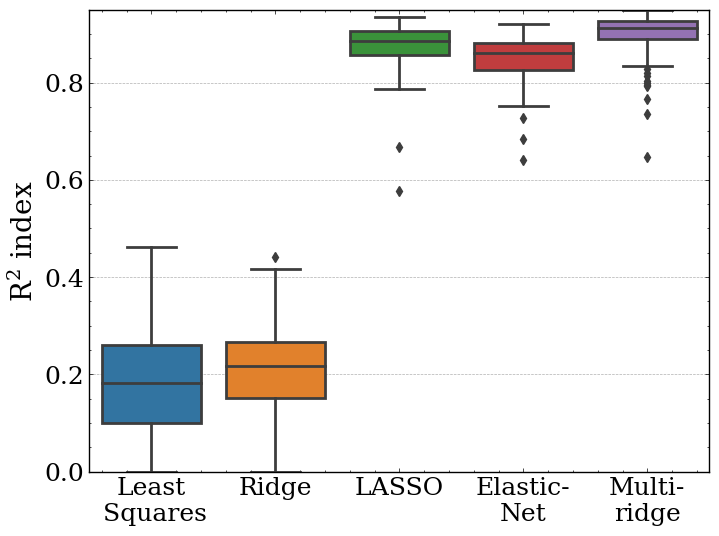

In [27]:
sys.path.append('..')
from src.configs import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

fig_params['axes.labelsize'] = 20
fig_params['xtick.labelsize'] = 18
fig_params['ytick.labelsize'] = 18
fig_params['legend.fontsize'] = 19

fig_params['lines.linewidth'] = 2.0
rcParams.update(fig_params)

data = np.array([r2_LS, r2_ridge, r2_lasso, r2_elnet, r2_multipar ])

data = np.transpose(data)

#np.save('../results/lpv/data_plot.npy', data)    # .npy extension is added if not given
#data = np.load('../results/lpv/data_plot.npy')    # remove comment to print new results
mask = data <0
data[mask] = 0 
df = pd.DataFrame(data, columns=['Least\n Squares', 'Ridge', 'LASSO', 'Elastic-\nNet', 'Multi-\nridge'])

cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(8,6))#plt.figure(figsize=(8*cm,8*cm ))
ax = sns.boxplot(data=df)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5}) 

plt.ylabel(r'R$^2$ index')
#plt.grid()
fig_params['axes.grid'] = True
ax.set_axisbelow(True)

plt.savefig("../figures/pdf/LPV_BP.pdf",   dpi=300, bbox_inches='tight')

plt.show()